## Import packages

In [1]:
library(devtools)
# library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
# library(quantmod)
# library(xts)
# library(zoo)
library(gridExtra)
# library(tibble)
library(grid)
# library(future)
# library(future.apply)
# library(DescTools)
# library(rcompanion)
# library(tidyverse)
library(parallel)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
source("forecast_research/finance/markets_functions.R")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
load_all("forecast_research/vendor/hmmTMB")

ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB



In [4]:
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")

Skipping install of 'hmmTMB' from a local remote, the SHA1 (1.1.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
options(warn = -1)

## Import close data

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index, Shipping_Futures



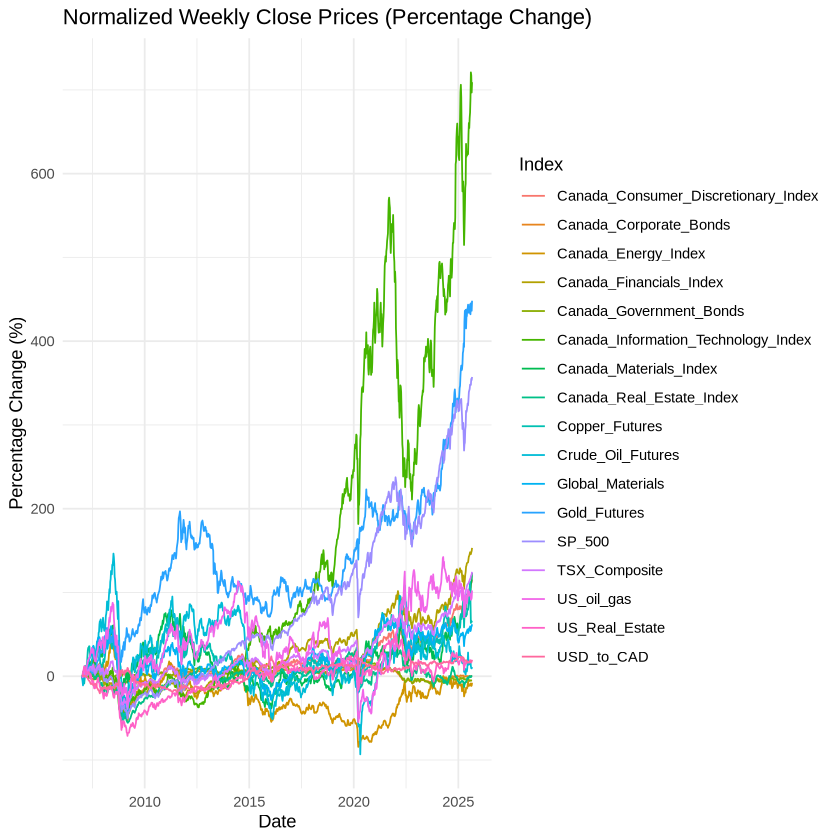

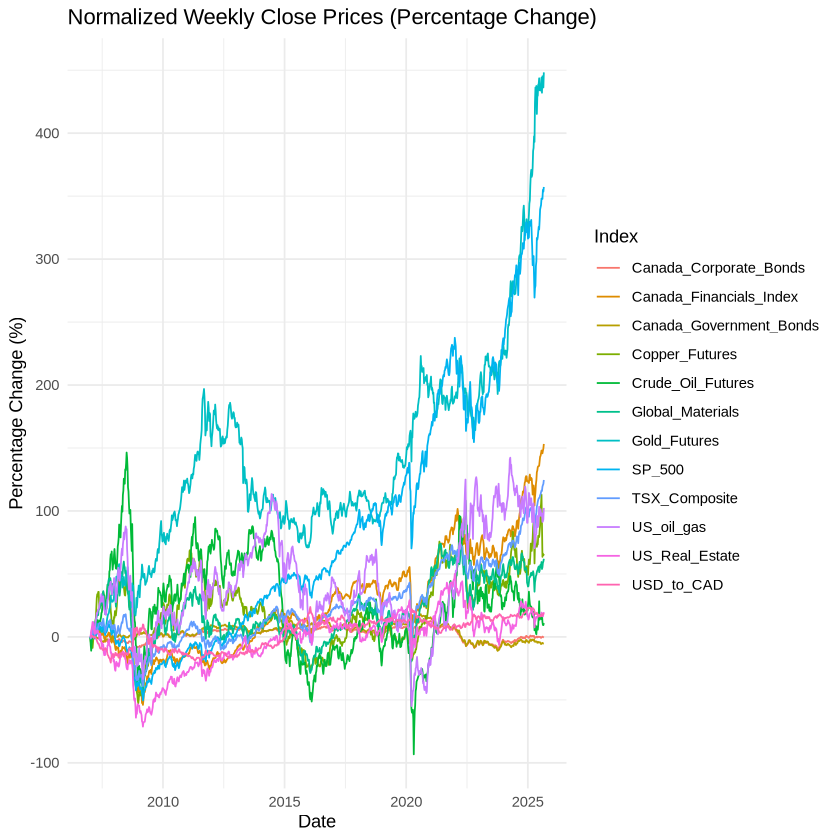

In [6]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

# Reshape data for ggplot
close_data_long <- close_data %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100)

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

In [9]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
test_size <- 2
buffer_size <- 5
n_samples <- 1
n_states <- 3
obs_name <- "TSX_Composite"
cov_name <- "Gold_Futures"
eval_range <- setNames(list(seq(from = -0.2, to = 0.2, by = 0.001)), obs_name)
log_data <- ln_transform(close_data)

log_data$lagged_tsx <- lag(log_data$TSX_Composite, 8)
log_data <- log_data[10:nrow(log_data), ]

samples <- train_test_split(
    log_data,
    training_period = train_size,
    testing_period  = test_size + buffer_size,
    samples         = n_samples
  )

# train_sample <- samples$train[[1]]
# test_sample  <- samples$test[[1]][0:test_size, ]
# total_sample <- rbind(samples$train[[1]], samples$test[[1]])

In [10]:
library(R6)

HMMForecaster <- R6Class(
  "HMMForecaster",
  public = list(
    data = NULL,
    train_size = NULL,
    test_size = NULL,
    buffer_size = NULL,
    n_samples = NULL,
    n_states = NULL,
    obs_name = NULL,
    cov_name = NULL,
    eval_range = NULL,
    samples = NULL,
    ncores = NULL,

    hmms = NULL,
    hmm_forecasts = NULL,
    train_states = NULL,
    test_state_probs = NULL,
    cov_data = NULL,
    cov_formula = NULL,
    lag_hmms = NULL,
    cov_forecasts = NULL,
    hmm_evaluations = NULL,
    cov_hmm_evaluations = NULL,

    initialize = function(
      data,
      train_size,
      test_size = 2,
      buffer_size = 5,
      n_samples = 2,
      n_states = 3,
      obs_name = "TSX_Composite",
      cov_name = "Gold_Futures",
      eval_range = setNames(list(seq(from = -0.2, to = 0.2, by = 0.001)), obs_name)
    ) {
      self$data <- data
      self$train_size <- train_size
      self$test_size <- test_size
      self$buffer_size <- buffer_size
      self$n_samples <- n_samples
      self$n_states <- n_states
      self$obs_name <- obs_name
      self$cov_name <- cov_name
      self$eval_range <- eval_range
      self$samples <- private$init_samples()
      self$ncores <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", "1"))
    },

    run = function() {
      # Step 1: For each sample, fit HMM
      self$hmms <- private$fit_hmm_to_samples(
        self$samples,
        self$n_states,
        self$obs_name
      )

      # Step 2: For each hmm, perform forecast
      self$hmm_forecasts <- private$forecast_hmms(
        self$hmms,
        self$samples
      )

      # Step 3: for each sample get ground truth states
      private$compute_states_from_hmm(
        self$hmms,
        self$samples
      )

      # Step 4: for each sample construct coavariate hidden states
      self$cov_data <- private$compute_cov_data(
        self$samples
      )
      self$cov_formula <- private$compute_cov_formula()

      # Step 5: Compute lagged HMMs with covariates for each sample
      self$lag_hmms <- lapply(1:self$test_size, function(lag) {
        private$fit_cov_hmm(lag)
      })

      # Step 6: Forecast with lagged HMMs
      self$cov_forecasts <- lapply(1:self$test_size, function(lag) {
        private$forecast_cov_hmms(lag)
      })

      # Step 7: Evaluate hmm forecasts
      self$hmm_evaluations <- private$evaluate_forecasts(self$hmm_forecasts, self$test_size)

      self$cov_hmm_evaluations <- lapply(1:self$test_size, function(lag) {
        private$evaluate_forecasts(self$cov_forecasts[[lag]], lag)
      })
    },

    get_samples = function() {
      self$samples
    },

    get_hmms = function() {
      self$hmms
    },

    get_cov_data = function() {
      self$cov_data
    },

    get_cov_formula = function() {
      self$cov_formula
    }

  ),
  private = list(
    init_samples = function() {
      nrows <- nrow(self$data)
      split_index <- as.integer(seq(
        from = self$train_size,
        to = nrows - self$test_size - self$buffer_size,
        length.out = self$n_samples
      ))
      samples <- lapply(split_index, function(idx) {
        train <- self$data[(idx - self$train_size + 1):idx, ]
        test <- self$data[(idx + 1):(idx + self$test_size), ]
        buffer <- self$data[(idx + self$test_size + 1):(idx + self$test_size + self$buffer_size), ]
        list(
          train = train,
          test = test,
          buffer = buffer
        )
      })
      samples
    },

    fit_hmm_to_samples = function(samples, n_states, obs_name) {
      mclapply(samples, function(sample) {
        train_data <- sample$train
        hid_model <- MarkovChain$new(
          data = train_data,
          n_states = n_states,
          formula = ~1,
          initial_state = "estimated"
        )
        obs_model <- Observation$new(
          data = train_data,
          n_states = n_states,
          dists = setNames(list("norm"), obs_name),
          par = setNames(
            list(
              list(
                mean = seq(-0.02, 0.01, length.out = n_states),
                sd = seq(0.1, 0.01, length.out = n_states)
              )
            ),
            obs_name
          )
        )

        hmm <- HMM$new(hid = hid_model, obs = obs_model)
        hmm$fit(silent = TRUE)
        hmm
      }, mc.cores = self$ncores, mc.set.seed = TRUE)
    },

    forecast_hmms = function(hmms, samples) {
      mapply(function(hmm, sample) {
        Forecast$new(
          hmm                        = hmm,
          forecast_data              = sample$test,
          starting_state_distribution = "last",
          preset_eval_range          = self$eval_range
        )
      }, hmms, samples, SIMPLIFY = FALSE)
    },

    compute_states_from_hmm = function(hmms, samples) {
      self$train_states <- list()
      self$test_state_probs <- list()
      invisible(mapply(function(hmm, sample) {
        full_data <- rbind(sample$train, sample$test, sample$buffer)
        hid_model <- MarkovChain$new(
          data = full_data,
          n_states = self$n_states,
          formula = ~1,
          initial_state = "estimated"
        )
        obs_model <- Observation$new(
          data = full_data,
          n_states = self$n_states,
          dists = setNames(list("norm"), self$obs_name),
          par = setNames(
            list(
              list(
                mean = seq(-0.02, 0.01, length.out = self$n_states),
                sd = seq(0.1, 0.01, length.out = self$n_states)
              )
            ),
            self$obs_name
          )
        )
        full_hmm <- HMM$new(init = hmm, hid = hid_model, obs = obs_model)
        
        states_vector <- unlist(full_hmm$states()[0:self$train_size])
        self$train_states <- c(self$train_states, list(states_vector))

        state_probs_matrix <- full_hmm$state_probs()[(self$train_size + 1):(self$train_size + self$test_size), ]
        self$test_state_probs <- c(self$test_state_probs, list(state_probs_matrix))
      }, hmms, samples, SIMPLIFY = FALSE))
    },

    compute_cov_data = function(samples) {
      # To be implemented
      cov_hmm_list <- private$fit_hmm_to_samples(samples, self$n_states, self$cov_name)
      
      lapply(cov_hmm_list, function(hmm) {
        cov_states <- hmm$state_probs()
        colnames(cov_states) <- paste0(self$cov_name, "_State_", seq_len(self$n_states))
        cov_states
      })
    },

    compute_cov_formula = function() {
      formula_parts <- paste0(self$cov_name, "_State_", seq_len(self$n_states))
      formula_str <- paste(formula_parts, collapse = " + ")
      as.formula(paste("~ 1 +", formula_str))
    },

    split_cov_data = function(cov_data, sample, train_state, lag) {
      lagged_cov <- rbind(
        matrix(NA, nrow = lag, ncol = self$n_states),
        cov_data
      )
      # Create full combined data
      train_data <- data.frame(
        obs = sample$train[[self$obs_name]],
        state = train_state,
        lagged_cov[1:self$train_size, , drop = FALSE],
        check.names = FALSE
      )
      names(train_data)[1] <- self$obs_name
      test_data <- data.frame(
        lagged_cov[(self$train_size + 1):(self$train_size + lag), , drop = FALSE],
        check.names = FALSE
      )
      # Always cut the first n rows so that all lags have the same test size.
      train_data <- train_data[(self$test_size + 1):self$train_size, ]
      list(train_data = train_data, test_data = test_data)
    },

    fit_cov_hmm = function(lag) {
      mcmapply(function(cov_data, sample, hmm, state) {
        cov_split <- private$split_cov_data(cov_data, sample, state, lag)
        train_data <- cov_split$train_data
        
        # Create semi supervised hidden model using covariates and known states
        hid_model <- MarkovChain$new(
          data = train_data,
          n_states = self$n_states,
          formula = self$cov_formula,
          initial_state = "estimated"
        )
        # Initialize observation model using previous hmm parameters
        par0 <- setNames(
          list(
            list(
              mean = hmm$par()$obspar[seq(1, length(hmm$par()$obspar), by = 2)],
              sd = hmm$par()$obspar[seq(2, length(hmm$par()$obspar), by = 2)]
            )
          ),
          self$obs_name
        )
        obs_model <- Observation$new(
          data = train_data,
          n_states = self$n_states,
          dists = setNames(list("norm"), self$obs_name),
          par = par0
        )
        obs_names <- rownames(hmm$obs()$coeff_fe())
        fixpar <- list(obs = setNames(rep(NA, length(obs_names)), obs_names))

        cov_hmm <- HMM$new(hid = hid_model, obs = obs_model, fixpar = fixpar)
        cov_hmm$fit(silent = TRUE)
        cov_hmm
      }, self$cov_data, self$samples, self$hmms, self$train_states, SIMPLIFY = FALSE,
      mc.cores = self$ncores, mc.set.seed = TRUE)
      
    },

    forecast_cov_hmms = function(lag) {
      mapply(function(cov_hmm, sample, cov_data) {
        cov_split <- private$split_cov_data(cov_data, sample, rep(0, times = nrow(sample$train)), lag)
        test_data <- cov_split$test_data
        Forecast$new(
          hmm                        = cov_hmm,
          forecast_data              = test_data,
          starting_state_distribution = "last",
          preset_eval_range          = self$eval_range
        )
      }, self$lag_hmms[[lag]], self$samples, self$cov_data, SIMPLIFY = FALSE)
    },

    evaluate_forecasts = function(hmm_forecasts, test_size) {
      sample_cross_entropy <- mapply(function(forecast, true_states) {
        forecast_states <- matrix(
          forecast$hidden_state_forecast(),
          ncol = n_states,
          byrow = TRUE
        )
        true_states <- true_states[(1:test_size), , drop = FALSE]
        state_cross_entropy <- as.matrix(
          -rowSums(true_states * log(forecast_states + 1e-10))
          , nrow = test_size, ncol = -1
        )
      }, hmm_forecasts, self$test_state_probs, SIMPLIFY = FALSE)
      ce_matrix <- do.call(cbind, sample_cross_entropy)
      colnames(ce_matrix) <- paste0("Sample_", seq_len(ncol(ce_matrix)))
      means <- rowMeans(ce_matrix, na.rm = TRUE)
      medians <- apply(ce_matrix, 1, median, na.rm = TRUE)
      percentile_25 <- apply(ce_matrix, 1, function(x) quantile(x, 0.25, na.rm = TRUE))
      percentile_75 <- apply(ce_matrix, 1, function(x) quantile(x, 0.75, na.rm = TRUE))
      list(
        mean = means,
        median = medians,
        percentile_25 = percentile_25,
        percentile_75 = percentile_75,
        samples = ce_matrix
      )
    }
  ) # Close private list
)

In [11]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
test_size <- 15
buffer_size <- 5
n_samples <- 25
n_states <- 3
obs_name <- "TSX_Composite"
cov_name <- "Gold_Futures"
eval_range <- setNames(list(seq(from = -0.2, to = 0.2, by = 0.001)), obs_name)

remove(forecaster)

forecaster <- HMMForecaster$new(
  data = log_data,
  train_size = train_size,
  test_size = test_size,
  buffer_size = buffer_size,
  n_samples = n_samples,
  n_states = n_states,
  obs_name = obs_name,
  cov_name = cov_name,
  eval_range = eval_range
)
forecaster$run()

# Max_test_size of 2
# n_smaples of 25
# Took 41s

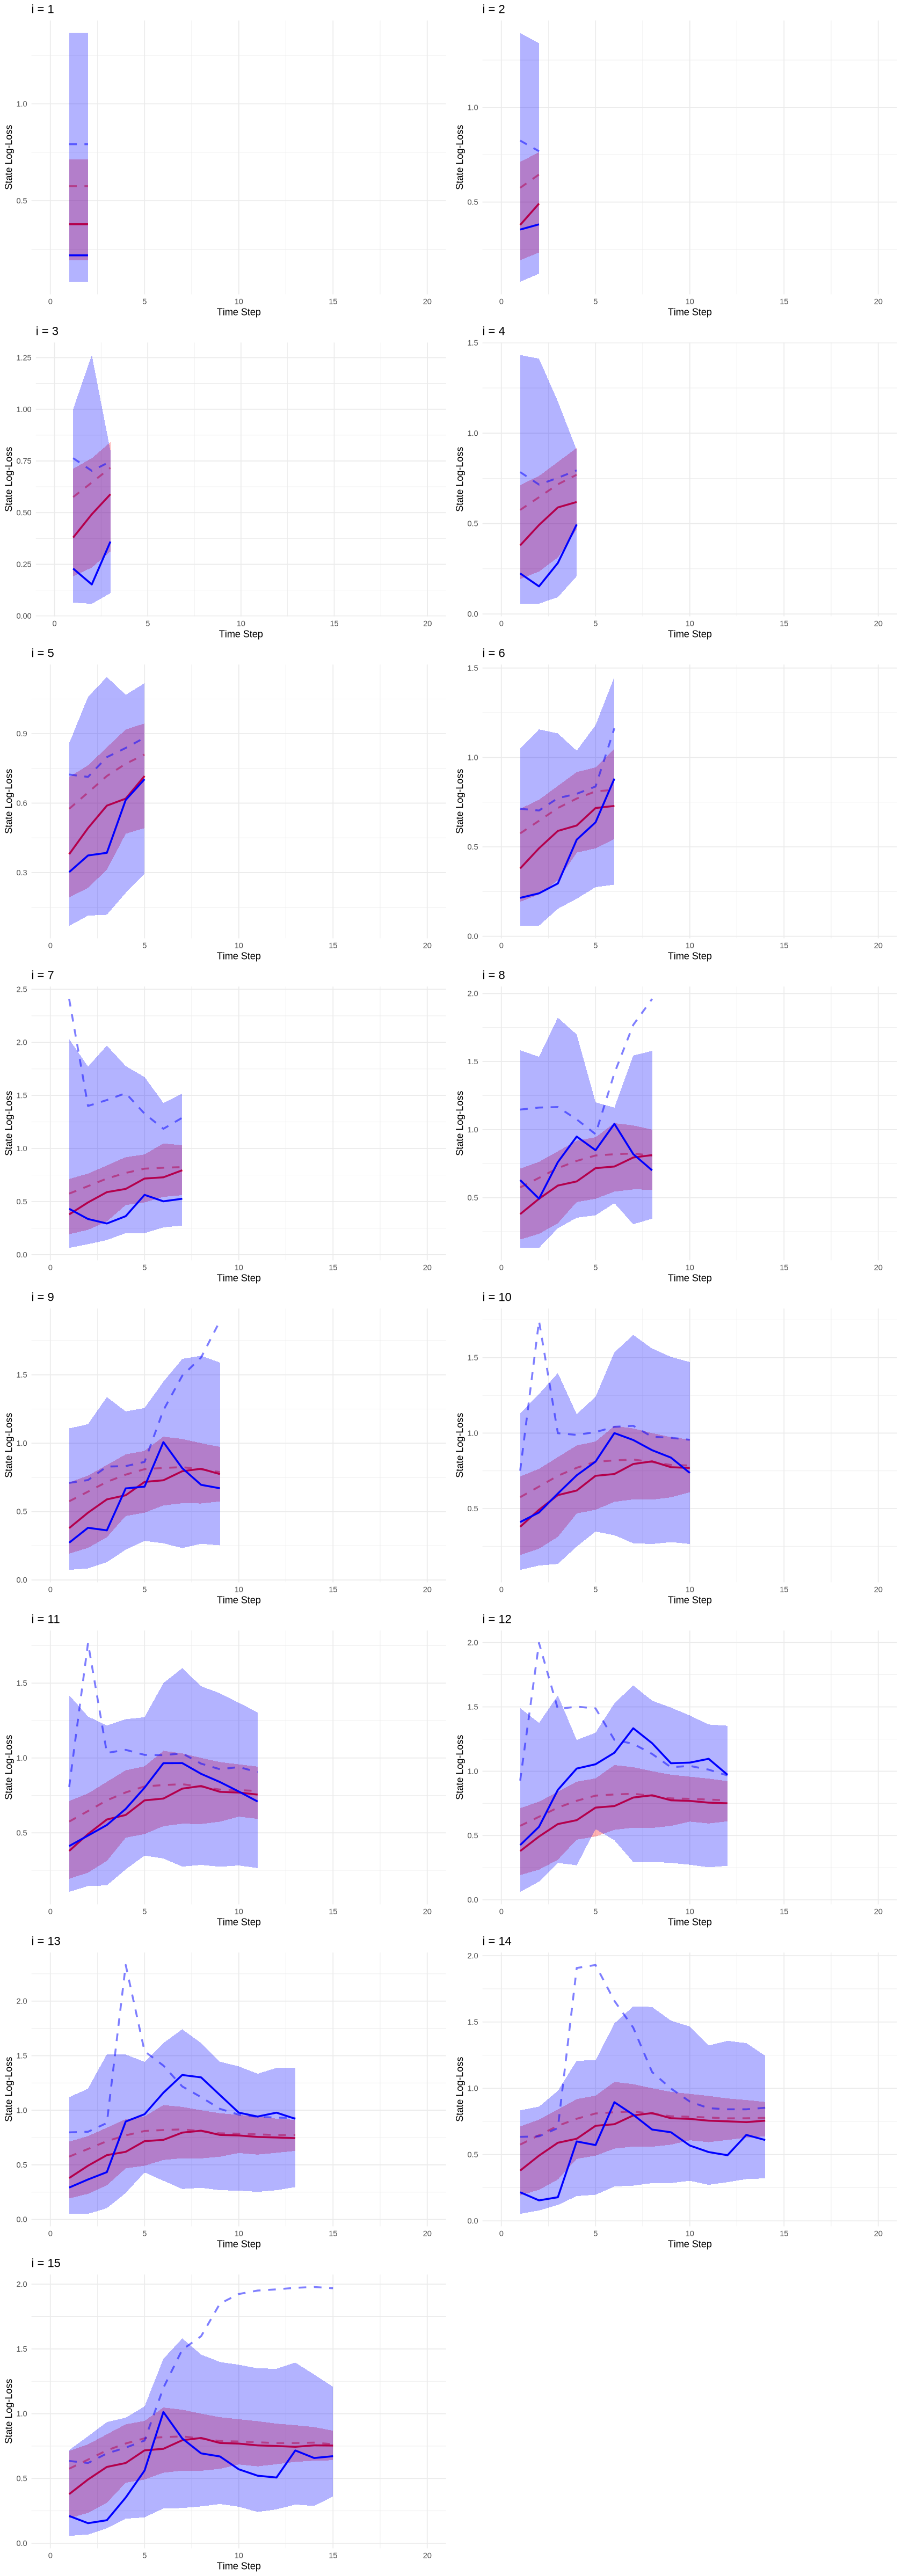

In [12]:
hmm_evals <- forecaster$hmm_evaluations
cov_evals <- forecaster$cov_hmm_evaluations

plot_list <- lapply(1:length(cov_evals), function(i) {
  plot_data <- data.frame(
    x = 1:i,
    median = hmm_evals$median[1:i],
    lower = hmm_evals$percentile_25[1:i],
    upper = hmm_evals$percentile_75[1:i],
    mean = hmm_evals$mean[1:i],
    cov_median = cov_evals[[i]]$median,
    cov_lower = cov_evals[[i]]$percentile_25,
    cov_upper = cov_evals[[i]]$percentile_75,
    cov_mean = cov_evals[[i]]$mean
  )
  if (i == 1) {
    plot_data <- rbind(plot_data, plot_data)
    plot_data$x[2] <- 2
  }

  ggplot(plot_data, aes(x = x)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
    geom_line(aes(y = median), color = "red", linewidth = 1) +
    geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
    geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
    geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    labs(x = "Time Step", y = "State Log-Loss", title = paste("i =", i)) +
    xlim(0, 20) +
    theme_minimal()
})

options(repr.plot.width = 14, repr.plot.height = 40)
grid.arrange(grobs = plot_list, ncol = 2)

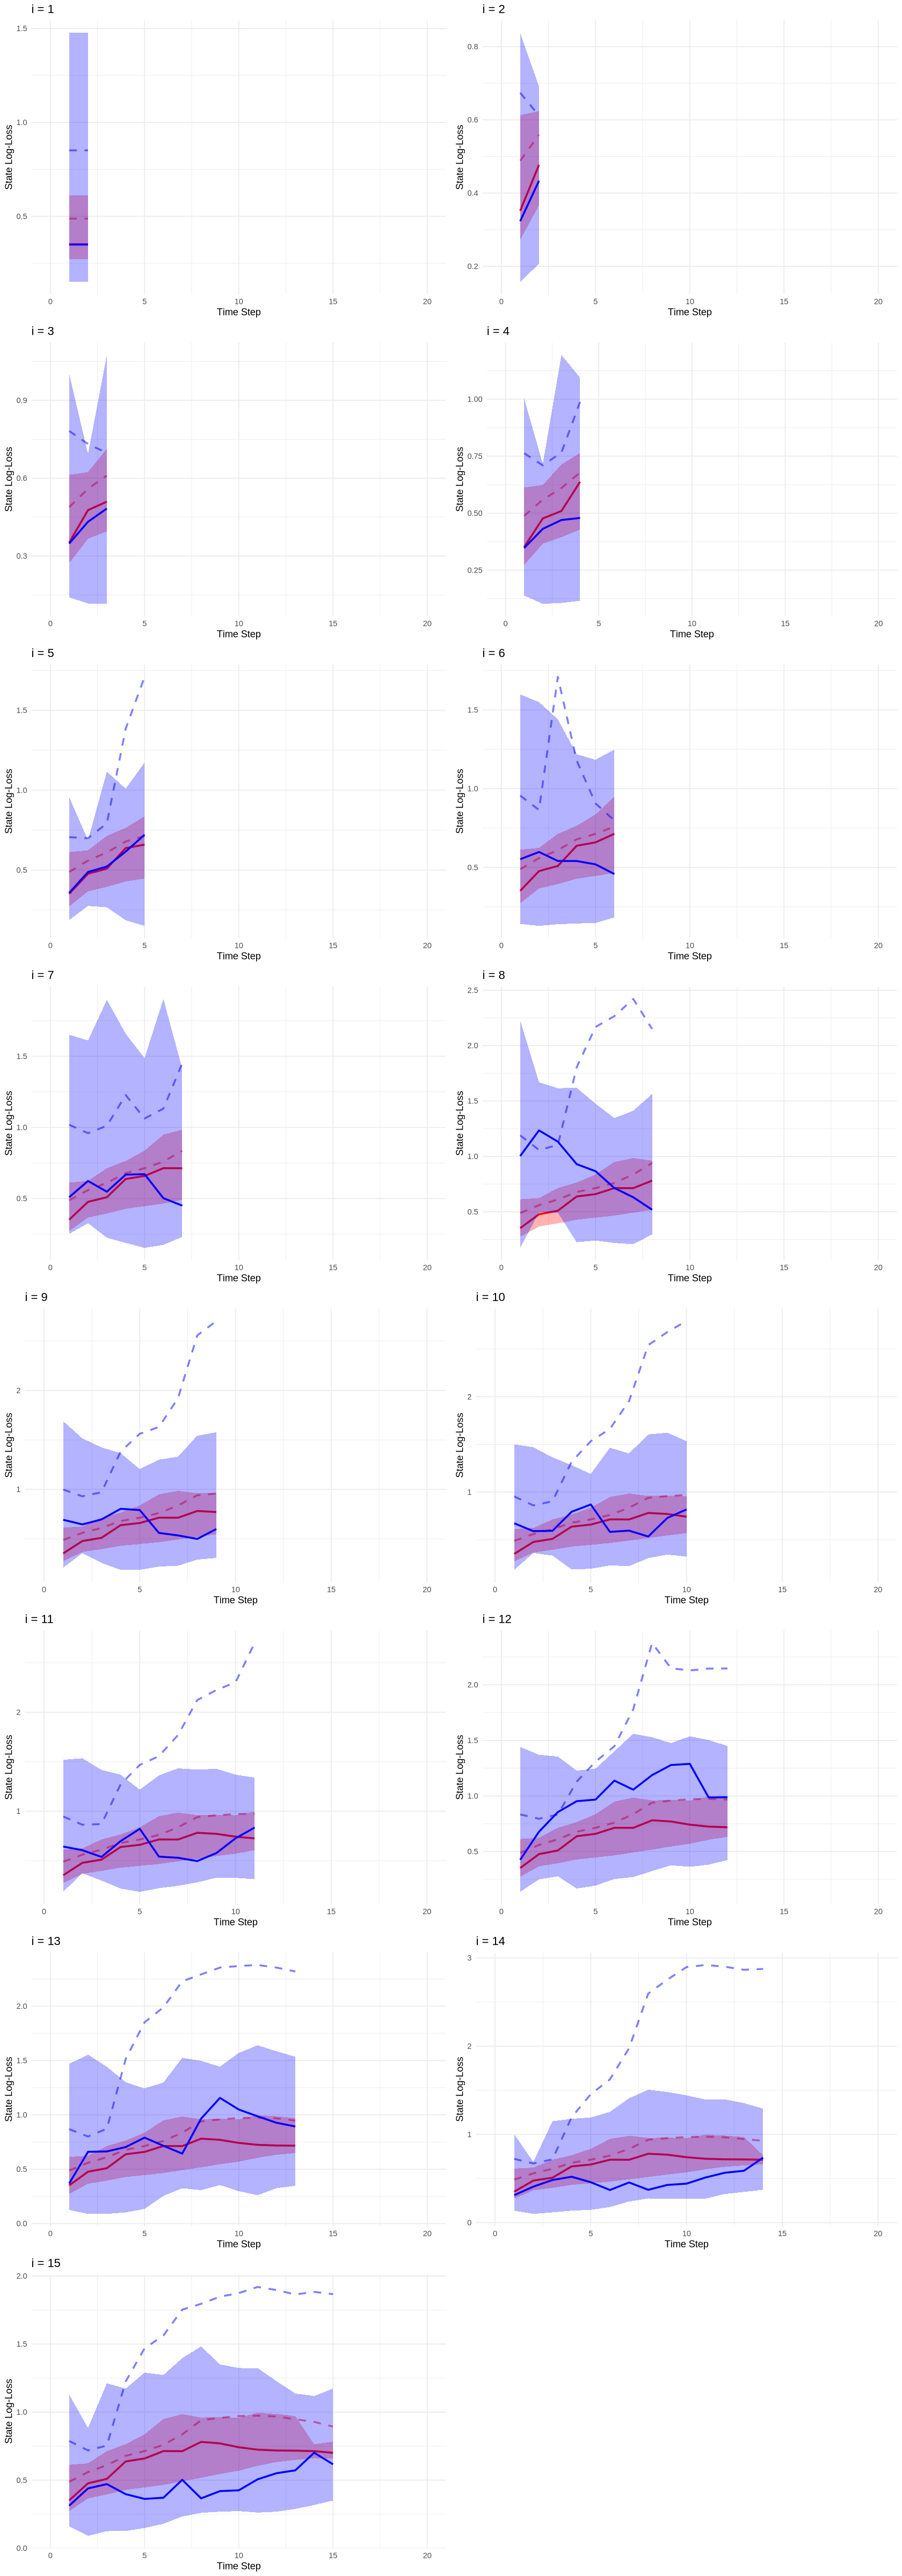

In [10]:
hmm_evals <- forecaster$hmm_evaluations
cov_evals <- forecaster$cov_hmm_evaluations

plot_list <- lapply(1:length(cov_evals), function(i) {
  plot_data <- data.frame(
    x = 1:i,
    median = hmm_evals$median[1:i],
    lower = hmm_evals$percentile_25[1:i],
    upper = hmm_evals$percentile_75[1:i],
    mean = hmm_evals$mean[1:i],
    cov_median = cov_evals[[i]]$median,
    cov_lower = cov_evals[[i]]$percentile_25,
    cov_upper = cov_evals[[i]]$percentile_75,
    cov_mean = cov_evals[[i]]$mean
  )
  if (i == 1) {
    plot_data <- rbind(plot_data, plot_data)
    plot_data$x[2] <- 2
  }

  ggplot(plot_data, aes(x = x)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
    geom_line(aes(y = median), color = "red", linewidth = 1) +
    geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
    geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
    geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    labs(x = "Time Step", y = "State Log-Loss", title = paste("i =", i)) +
    xlim(0, 20) +
    theme_minimal()
})

options(repr.plot.width = 14, repr.plot.height = 40)
grid.arrange(grobs = plot_list, ncol = 2)

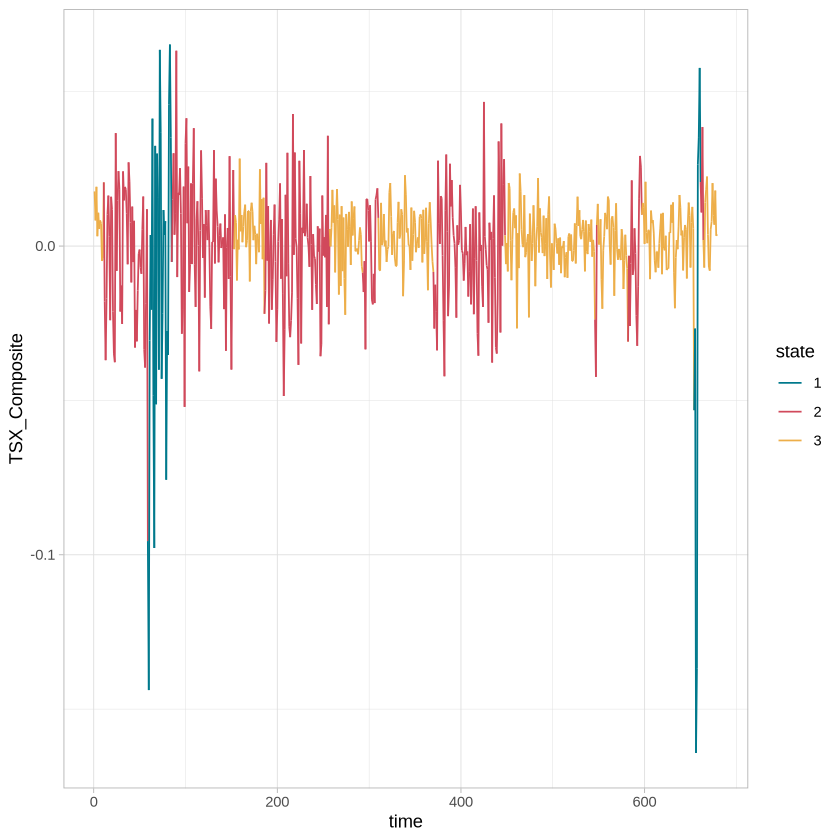

In [11]:
forecaster$hmms[[4]]$plot_ts(obs_name)

In [ ]:
forecaster$cov_forecasts[[15]][[4]]$hidden_state_forecast()

0.0008547232
0.0280219328
0.9711233440


In [167]:
forecaster$cov_forecasts[[2]][[4]]$hidden_state_forecast()

0.002271837,0.004517735
0.025951397,0.049436093
0.971776767,0.946046171


In [168]:
forecaster$hmm_forecasts[[4]]$hidden_state_forecast()

0.002796195,0.004784573
0.084368476,0.119901191
0.912835330,0.875314236


In [12]:
forecaster$hmm_evaluations

Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,⋯,Sample_16,Sample_17,Sample_18,Sample_19,Sample_20,Sample_21,Sample_22,Sample_23,Sample_24,Sample_25
0.2883259,0.1811123,1.3369498,0.8657601,0.2824559,0.7258329,0.4349713,0.1040631,0.6935117,0.2541580,⋯,0.7751932,0.5541756,0.4771926,1.7166588,0.1016545,0.4740535,1.0613593,0.9070089,1.7086411,0.5504997
0.3760192,0.2626741,1.3588761,1.3463094,0.5335193,0.7268303,0.4381642,0.1461049,0.7104676,0.3222485,⋯,0.8341467,0.5258776,0.4834216,1.7791269,0.1299620,0.4860558,1.1239415,0.8821795,1.2141938,0.5870132
0.4743348,0.3478274,1.3549061,1.5543373,1.0156589,0.6936963,0.4496203,0.1855488,0.7912904,0.3618006,⋯,0.9908946,0.5256985,0.4749202,1.7049346,0.1627294,0.4831794,1.3080597,0.8505708,1.0068961,0.6243713
0.6377307,1.2507480,1.3499695,1.4905888,1.1157642,0.6811135,0.4642669,0.2163981,0.7905961,0.3709319,⋯,1.0306647,0.5451282,0.4838308,1.6023870,0.1919811,0.4934687,1.7403583,0.8235040,0.9038103,0.6896816
0.8362394,1.5659076,1.2910323,1.5262937,1.1476104,0.6761256,0.4792745,0.2467317,0.7572118,0.4050250,⋯,1.0096594,0.5915400,0.5039563,1.4997324,0.2235655,0.5149757,1.6115065,0.7955113,0.8846505,0.7220693
1.2635776,1.5849969,1.2142066,1.4116470,1.1204039,0.6787548,0.4927235,0.2795574,0.7628706,0.4194916,⋯,0.9785656,0.6292762,0.5262211,1.4096165,0.2523364,0.5371697,1.2770514,0.7714485,0.8776047,0.7323280
2.1048544,1.9707456,1.1805491,1.3412614,1.0573698,0.6732337,0.5050629,0.3168481,0.8063790,0.4295656,⋯,0.9388794,0.7116144,0.5479134,1.3278606,0.2810563,0.5705194,1.0276926,0.7485291,0.8126047,0.7270746
4.3414100,2.0382328,1.1320468,1.2877006,0.9993249,0.6720594,0.5168403,0.3483953,0.8659134,0.4640999,⋯,0.8780801,0.7869689,0.5662091,1.2585438,0.3133599,0.5916829,0.9199956,0.7292706,0.8046607,0.7245769
4.6173261,2.0514139,1.0687253,1.2709718,0.9536964,0.6649369,0.5282567,0.3850025,1.0157010,0.5097198,⋯,0.8236331,0.9260025,0.6160020,1.1961832,0.3494308,0.5991085,0.7726360,0.7135473,0.8279354,0.7127646
4.9150096,2.0228332,1.0254468,1.2414133,0.8858896,0.6646460,0.5392773,0.4365694,1.1435119,0.5411626,⋯,0.8546623,0.9345421,0.6593690,1.1427414,0.3981219,0.6220115,0.6850505,0.7030863,0.9093551,0.7037430


In [13]:
forecaster$cov_hmm_evaluations

Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,⋯,Sample_16,Sample_17,Sample_18,Sample_19,Sample_20,Sample_21,Sample_22,Sample_23,Sample_24,Sample_25
0.3103355,1.001225,2.376032,3.178905,0.3461198,2.284785,0.2018616,0.04342704,1.433304,NaN,⋯,3.049675,3.054501,0.449154,2.975432,0.05252431,0.5072933,1.986171,0.6315648,2.99211,0.1631979
Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,⋯,Sample_16,Sample_17,Sample_18,Sample_19,Sample_20,Sample_21,Sample_22,Sample_23,Sample_24,Sample_25
0.3217625,0.2275735,NaN,2.806444,NaN,2.168799,0.2016569,0.04948053,1.425060,0.2248747,⋯,8.218039,2.870286,0.4405804,2.769354,0.05486127,0.5823579,1.901726,0.6453443,3.030568,0.1609944
0.4311466,0.3747157,NaN,1.395484,NaN,1.848227,0.1162867,0.07665732,1.294596,0.2770047,⋯,1.875228,2.477792,0.3176182,2.914514,0.06130907,0.5107869,1.922768,0.4328248,1.970154,0.1499394
Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,⋯,Sample_16,Sample_17,Sample_18,Sample_19,Sample_20,Sample_21,Sample_22,Sample_23,Sample_24,Sample_25
0.3235948,1.005737,2.543783,2.556302,NaN,2.402813,0.20148252,NaN,1.420006,NaN,⋯,7.423617,2.865968,0.4844008,2.513913,0.05362810,0.5808285,1.958106,0.6358738,NaN,0.1857004
0.4301992,1.673168,2.488609,1.237367,NaN,2.002874,0.11677336,NaN,1.290315,NaN,⋯,6.658142,2.455910,0.3455438,2.681619,0.05742122,0.5069489,2.095116,0.4378009,NaN,0.1843839
0.5780578,1.343198,2.465148,0.608363,NaN,1.295402,0.09781046,NaN,1.409526,NaN,⋯,5.133955,2.174700,0.1515478,2.722192,0.07038936,0.4065929,2.469054,0.3689528,NaN,0.2077046
Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,⋯,Sample_16,Sample_17,Sample_18,Sample_19,Sample_20,Sample_21,Sample_22,Sample_23,Sample_24,Sample_25
0.3203862,1.005737,2.541926,2.3804430,0.3645900,2.3602632,0.20162164,0.04491995,1.425034,0.2268965,⋯,7.019906,NaN,0.48543628,2.557242,0.05359427,0.5502971,1.920910,0.6310501,NaN,0.1884842


In [100]:
forecaster$train_states[[10]]

[1] 3 3 3 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2
[223] 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[260] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2
[297] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[334] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[371] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[408] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[445] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3
[482] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2
[519] 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[556] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 2 2 2 2 2 2 2
[593] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[630] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[667] 3 3 3 2 2 2 2 2 2 2 2 2 2

In [45]:
forecaster$get_cov_formula()

~1 + Gold_Futures_State_1 + Gold_Futures_State_2 + Gold_Futures_State_3
<environment: 0x130cb888>

In [ ]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
test_size <- 20
buffer_size <- 5
n_samples <- 2
n_states <- 3
obs_name <- "TSX_Composite"
cov_name <- "Gold_Futures"
eval_range <- setNames(list(seq(from = -0.2, to = 0.2, by = 0.001)), obs_name)
log_data <- ln_transform(close_data)

samples <- train_test_split(
    log_data,
    training_period = train_size,
    testing_period  = test_size + buffer_size,
    samples         = n_samples
  )

results <- list()
for (i in seq_along(samples$train)) {
  train_sample <- samples$train[[i]]
  test_sample  <- samples$test[[i]][0:test_size, ]
  total_sample <- rbind(samples$train[[i]], samples$test[[i]])

  # Step 1: Get hmm on training data to aquire obs parameters
  hmm <- fit_hmm(
    data        = train_sample,
    obs_name    = obs_name,
    n_states    = n_states,
    hid_formula = as.formula(" ~ 1"),
    horseshoe   = FALSE
  )
  hmm_forecast <- Forecast$new(
    hmm                        = hmm,
    forecast_data              = test_sample,
    starting_state_distribution = "last",
    preset_eval_range          = eval_range
  )

  # Step 2: Get Ground truth state labels on full data including end buffer using obs parameters from hmm
  hmm_2 <- fit_hmm(
    data        = total_sample,
    obs_name    = obs_name,
    n_states    = n_states,
    hid_formula = as.formula(" ~ 1"),
    horseshoe   = FALSE,
    init = hmm
  )

  true_states <- hmm_2$states()
  true_test_states <- hmm_2$state_probs()[(train_size + 1):(train_size + test_size), ]

  # Step 3: Get covariate values using the train_sample
  covariate <- fit_hmm(
    data        = train_sample,
    obs_name    = cov_name,
    n_states    = n_states,
    hid_formula = ~ 1,
    horseshoe   = FALSE
  )

  cov_states <- covariate$state_probs()
  colnames(cov_states) <- paste0(cov_name, "_State_", seq_len(n_states))

  # Formula: obs ~ 1 + cov_name_State_1 + ... + cov_name_State_K
  cov_formula <- as.formula(
    paste0(" ~ 1 + ", paste(colnames(cov_states), collapse = " + "))
  )

  # Step 4: For each lag period construct lagged covariate training data and train cov_hmm
  lag_results <- list()
  for (lag in 1:test_size) {
    lagged_cov <- rbind(
      matrix(NA, nrow = lag, ncol = ncol(cov_states)),
      cov_states
    )

    # Create full combined data with
    train_data <- data.frame(
      obs = train_sample[[obs_name]],
      state = true_states[1:train_size],
      lagged_cov[1:train_size, , drop = FALSE],
      check.names = FALSE
    )
    names(train_data)[1] <- obs_name
    test_data <- data.frame(
      lagged_cov[(train_size + 1):(train_size + lag), , drop = FALSE],
      check.names = FALSE
    )

    # Create the Covariate HMM
    hid_model <- MarkovChain$new(
      data = train,
      n_states = n_states,
      formula = formula,
      initial_state = "estimated"
      #horseshoe = horseshoe
    )
    par0 <- setNames(
        list(
          list(
            mean = hmm$par()$obspar[seq(1, length(hmm$par()$obspar), by = 2)],
            sd = hmm$par()$obspar[seq(2, length(hmm$par()$obspar), by = 2)]
          )
        ),
        obs_name
      )

    obs_names <- rownames(hmm$obs()$coeff_fe())
    fixpar <- list(obs = setNames(rep(NA, length(obs_names)), obs_names))

    obs_model <- Observation$new(
      data = train,
      n_states = n_states,
      dists = setNames(list("norm"), obs_name),
      par = par0
    )

    cov_hmm <- HMM$new(hid = hid_model, obs = obs_model, fixpar = fixpar)
    cov_hmm$fit(silent = TRUE)
    
    cov_forecast <- Forecast$new(
      hmm                        = cov_hmm,
      forecast_data              = test_data,
      starting_state_distribution = "last",
      preset_eval_range          = eval_range
    )
    lag_results[[lag]] <- list(
      state_forecast = cov_forecast$hidden_state_forecast(),
      cov_model      = cov_hmm
    )
  }
  results[[i]] <- list(
    true_test_states = true_test_states,
    lag_results      = lag_results,
    hmm_forecast     = hmm_forecast
  )
}

In [139]:
cov_forecast$hidden_state_forecast()

7.682721e-321
1.780626e-02
9.821937e-01


In [111]:
# 1) Fit HMM on the covariate alone
if (!is.null(cov_name)) {
  covariate <- fit_hmm(
    data        = train_sample,
    obs_name    = cov_name,
    n_states    = n_states,
    hid_formula = ~ 1,
    horseshoe   = FALSE
  )

  cov_states <- covariate$state_probs()
  colnames(cov_states) <- paste0(cov_name, "_State_", seq_len(n_states))

  # Formula: obs ~ 1 + cov_name_State_1 + ... + cov_name_State_K
  formula <- as.formula(
    paste0(" ~ 1 + ", paste(colnames(cov_states), collapse = " + "))
  )
} else {
  cov_states <- matrix(NA, nrow = train_size, ncol = 1)
  formula <- as.formula(" ~ 1")
}

# 2) Lag covariate states by test_size
lagged_cov <- rbind(
  matrix(NA, nrow = test_size, ncol = ncol(cov_states)),
  cov_states
)

# Create full combined data with
combined <- data.frame(
  obs = rbind(train_sample, test_sample)[[obs_name]],
  state = true_states[1:(train_size + test_size)],
  lagged_cov,
  check.names = FALSE
)
names(combined)[1] <- obs_name  # rename "obs" column to obs_name

train <- combined[(max_test_size + 1):train_size, , drop = FALSE]
test  <- combined[(train_size + 1):(train_size + test_size), , drop = FALSE]

In [124]:
combined <- data.frame(
  obs = rbind(train_sample, test_sample)[[obs_name]],
  state = true_states[1:(train_size + test_size)],
  lagged_cov,
  check.names = FALSE
)

ERROR: Error in data.frame(obs = rbind(train_sample, test_sample)[[obs_name]], : arguments imply differing number of rows: 699, 620


In [75]:
dim(train)
tail(train, 2)
dim(test)
head(test, 2)

[1] 575   5

,TSX_Composite,state,Gold_Futures_State_1,Gold_Futures_State_2,Gold_Futures_State_3
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
599,0.005982546,3,0.001787487,0.044785184,0.9534273
600,-0.016111360,3,0.002129131,0.009448082,0.9884228


[1] 20  5

,TSX_Composite,state,Gold_Futures_State_1,Gold_Futures_State_2,Gold_Futures_State_3
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
601,0.004999923,3,0.0003032238,0.34057247,0.6591243
602,0.013860556,3,0.0006558072,0.01777877,0.9815654


In [112]:
hid_model <- MarkovChain$new(
  data = train,
  n_states = n_states,
  formula = formula,
  initial_state = "estimated"
  #horseshoe = horseshoe
)
par0 <- setNames(
    list(
      list(
        mean = hmm$par()$obspar[seq(1, length(hmm$par()$obspar), by = 2)],
        sd = hmm$par()$obspar[seq(2, length(hmm$par()$obspar), by = 2)]
      )
    ),
    obs_name
  )

obs_names <- rownames(hmm$obs()$coeff_fe())
fixpar <- list(obs = setNames(rep(NA, length(obs_names)), obs_names))

obs_model <- Observation$new(
  data = train,
  n_states = n_states,
  dists = setNames(list("norm"), obs_name),
  par = par0
)

cov_hmm <- HMM$new(hid = hid_model, obs = obs_model, fixpar = fixpar)
cov_hmm$fit(silent = TRUE)
cov_hmm

#######################
## Observation model ##
#######################
+ TSX_Composite ~ norm(mean, sd) 
  * mean.state1 ~ 1
  * mean.state2 ~ 1
  * mean.state3 ~ 1
  * sd.state1 ~ 1
  * sd.state2 ~ 1
  * sd.state3 ~ 1
 
> Estimated observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.006  -0.002   0.003
TSX_Composite.sd     0.045   0.019   0.009

#########################
## State process model ##
#########################
                                                                        state 1
state 1                                                                       .
state 2 ~1 + Gold_Futures_State_1 + Gold_Futures_State_2 + Gold_Futures_State_3
state 3 ~1 + Gold_Futures_State_1 + Gold_Futures_State_2 + Gold_Futures_State_3
                                                                        state 2
state 1 ~1 + Gold_Futures_State_1 + Gold_Futures_State_2 + Gold_Futures_State_3
state 2                                       

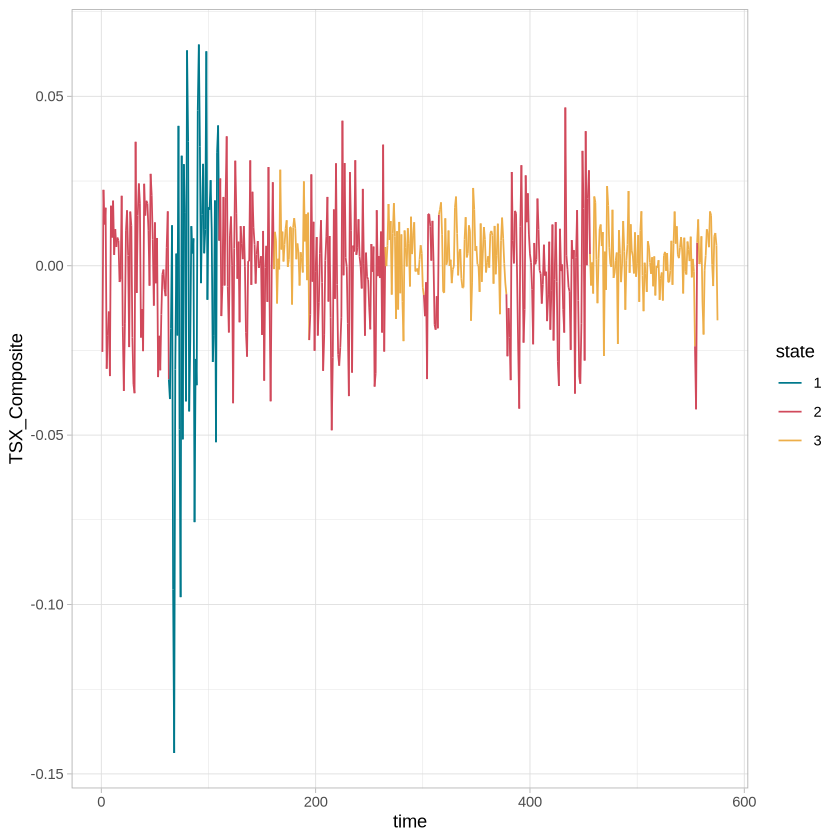

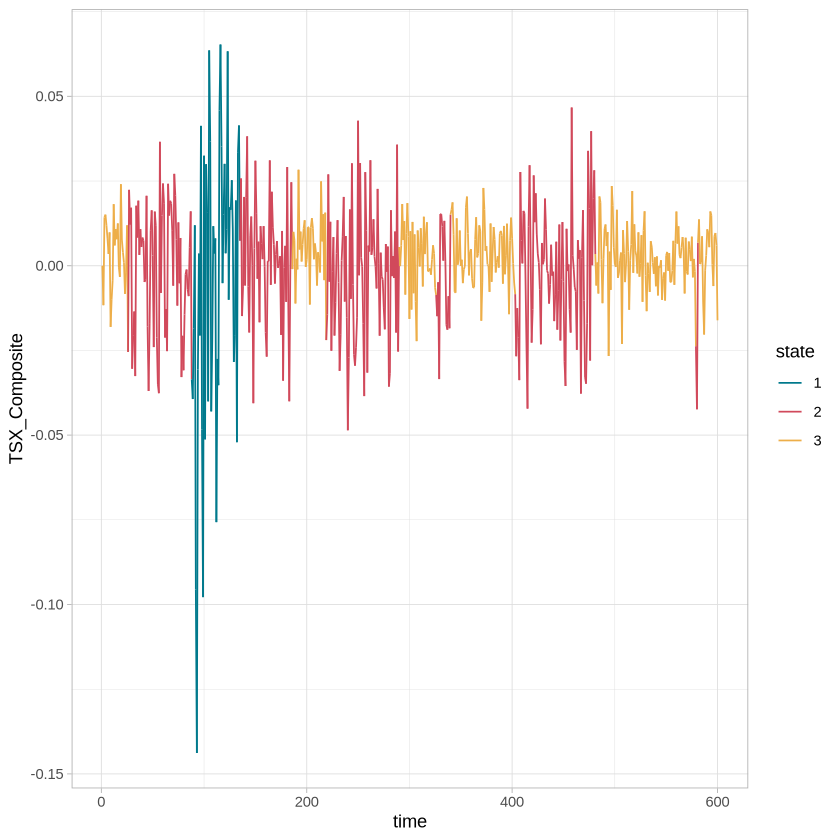

In [113]:
cov_hmm$plot_ts(obs_name)
hmm$plot_ts(obs_name)

In [115]:
hmm_forecast <- Forecast$new(
  hmm                        = hmm,
  forecast_data              = test,
  starting_state_distribution = "last",
  preset_eval_range          = eval_range
)
cov_forecast <- Forecast$new(
  hmm                        = cov_hmm,
  forecast_data              = test,
  starting_state_distribution = "last",
  preset_eval_range          = eval_range
)

In [116]:
hmm_forecast$hidden_state_forecast()

0.001721902,0.002992471,0.004294659,0.00562082,0.00696421,0.00831889,0.009679643,0.01104189,0.01240164,0.01375541,0.01510016,0.01643328,0.0177525,0.01905591,0.02034187,0.02160897,0.02285607,0.02408222,0.02528664,0.02646871
0.330854942,0.347157000,0.361744077,0.37479256,0.38646080,0.39689095,0.406210637,0.41453442,0.42196513,0.42859510,0.43450717,0.43977574,0.4444676,0.44864253,0.45235444,0.45565155,0.45857717,0.46117016,0.46346539,0.46549415
0.667423156,0.649850530,0.633961264,0.61958662,0.60657499,0.59479016,0.584109720,0.57442369,0.56563322,0.55764949,0.55039267,0.54379099,0.5377799,0.53230156,0.52730369,0.52273947,0.51856675,0.51474761,0.51124797,0.50803714


In [117]:
cov_forecast$hidden_state_forecast()

7.682721e-321,2.656871e-08,2.885532e-08,3.186759e-08,4.328395e-08,5.205152e-08,8.871971e-08,1.883160e-07,2.167135e-07,2.949572e-07,3.197795e-07,3.283449e-07,3.379209e-07,3.592343e-07,3.692905e-07,3.885249e-07,4.149844e-07,4.334926e-07,4.492675e-07,4.612290e-07
1.780626e-02,4.621577e-02,6.527434e-02,8.299569e-02,1.027601e-01,1.197156e-01,1.389369e-01,1.594081e-01,1.748022e-01,1.928892e-01,2.072775e-01,2.177236e-01,2.276790e-01,2.393728e-01,2.478273e-01,2.576147e-01,2.674385e-01,2.748291e-01,2.799660e-01,2.815485e-01
9.821937e-01,9.537842e-01,9.347256e-01,9.170043e-01,8.972399e-01,8.802844e-01,8.610630e-01,8.405917e-01,8.251976e-01,8.071105e-01,7.927222e-01,7.822761e-01,7.723207e-01,7.606269e-01,7.521724e-01,7.423849e-01,7.325611e-01,7.251705e-01,7.200336e-01,7.184511e-01


In [118]:
true_test_states

state1,state2,state3
2.007815e-06,0.03118273,0.968815260
1.962397e-06,0.02562036,0.974377673
1.574514e-06,0.02184838,0.978150049
1.515016e-06,0.02318468,0.976813807
1.768208e-06,0.02549890,0.974499328
2.315442e-06,0.03437876,0.965618922
3.473287e-06,0.04953427,0.950462254
5.665139e-06,0.07078826,0.929206076
9.075873e-06,0.12508298,0.874907943
1.747278e-05,0.25022716,0.749755368


In [ ]:
# # Fit HMM with covariates on train
# evaluate_model <- function(train, test, formula) {
combined   <- rbind(train, test)
train_size <- nrow(train)
test_size  <- nrow(test)

hmm <- fit_hmm(
  data        = train,
  obs_name    = obs_name,
  n_states    = n_states,
  hid_formula = formula,
  horseshoe   = FALSE
)
forecast <- Forecast$new(
  hmm                        = hmm,
  forecast_data              = test,
  starting_state_distribution = "last",
  preset_eval_range          = setNames(list(eval_range), obs_name)
)
true_model <- fit_hmm(
  data        = combined,
  obs_name    = obs_name,
  n_states    = n_states,
  hid_formula = formula,
  horseshoe   = FALSE,
  init        = hmm
)

# -- State forecast log-loss --
forecast_states <- matrix(
  forecast$hidden_state_forecast(),
  ncol = n_states,
  byrow = TRUE
)
true_states <- tail(true_model$state_probs(), test_size)

state_cross_entropy <- as.matrix(
  -rowSums(true_states * log(forecast_states + 1e-10))
  , nrow = test_size, ncol = -1
)

# --- Prediction log-loss ---
forecast_dists <- forecast$forecast_dists()[[obs_name]]
eval_range_loc <- forecast$eval_range()[[obs_name]]

prediction_loss <- numeric(test_size)
for (j in seq_len(test_size)) {
  pdf_val <- tryCatch(
    {
      val <- approx(
        x    = eval_range_loc,
        y    = forecast_dists[, j],
        xout = test[[obs_name]][j]
      )$y
    },
    error = function(e) NaN
  )
  prediction_loss[j] <- -log(pdf_val)
}

list(
  state_forecast     = forecast_states,
  true_states        = true_states,
  state_logloss      = state_cross_entropy,
  prediction_logloss = prediction_loss,
  hmm                = true_model,
  forecast           = forecast
)
# }

In [8]:
compute_cov_loss <- function(samples, obs_name, cov_name, n_states, eval_range, max_test_size) {
  # Number of time series samples
  n_series   <- length(samples$train)

  series     <- vector("list", n_series)

  train_size <- nrow(samples$train[[1]])
  test_size  <- nrow(samples$test[[1]])

  for (i in seq_len(n_series)) {
    train_sample <- samples$train[[i]]
    test_sample  <- samples$test[[i]]

    # 1) Fit HMM on the covariate alone
    if (!is.null(cov_name)) {
      covariate <- fit_hmm(
        data        = train_sample,
        obs_name    = cov_name,
        n_states    = n_states,
        hid_formula = ~ 1,
        horseshoe   = FALSE
      )

      cov_states <- covariate$state_probs()
      colnames(cov_states) <- paste0(cov_name, "_State_", seq_len(n_states))

      # Formula: obs ~ 1 + cov_name_State_1 + ... + cov_name_State_K
      formula <- as.formula(
        paste0(" ~ 1 + ", paste(colnames(cov_states), collapse = " + "))
      )
    } else {
      cov_states <- matrix(NA, nrow = train_size, ncol = 1)
      formula <- as.formula(" ~ 1")
    }

    # 2) Lag covariate states by test_size
    lagged_cov <- rbind(
      matrix(NA, nrow = test_size, ncol = ncol(cov_states)),
      cov_states
    )

    # Create full combined data with
    combined <- data.frame(
      obs = rbind(train_sample, test_sample)[[obs_name]],
      lagged_cov,
      check.names = FALSE
    )
    names(combined)[1] <- obs_name  # rename "obs" column to obs_name

    train <- combined[(max_test_size + 1):train_size, , drop = FALSE]
    test  <- combined[(train_size + 1):(train_size + test_size), , drop = FALSE]

    series[[i]] <- list(
      cov_model = evaluate_model(train, test, formula),
      tsx_model = evaluate_model(train, test, ~ 1)
    )
  }
  series
}


In [9]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
max_test_size <- 20
n_samples <- 25
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)
obs_name <- "TSX_Composite"
cov_name <- "Gold_Futures"
log_data <- ln_transform(close_data)

In [10]:
library(parallel)

n_cores    <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", "1"))
test_sizes <- seq_len(max_test_size)

rm(results)

parallel_fun <- function(test_size) {
  samples <- train_test_split(
    log_data,
    training_period = train_size,
    testing_period  = test_size,
    samples         = n_samples,
    max_test_size   = max_test_size
  )
  compute_cov_loss(samples, obs_name, cov_name, n_states, eval_range, max_test_size)
}

results <- mclapply(
  test_sizes,
  parallel_fun,
  mc.cores    = n_cores,
  mc.set.seed = TRUE
)

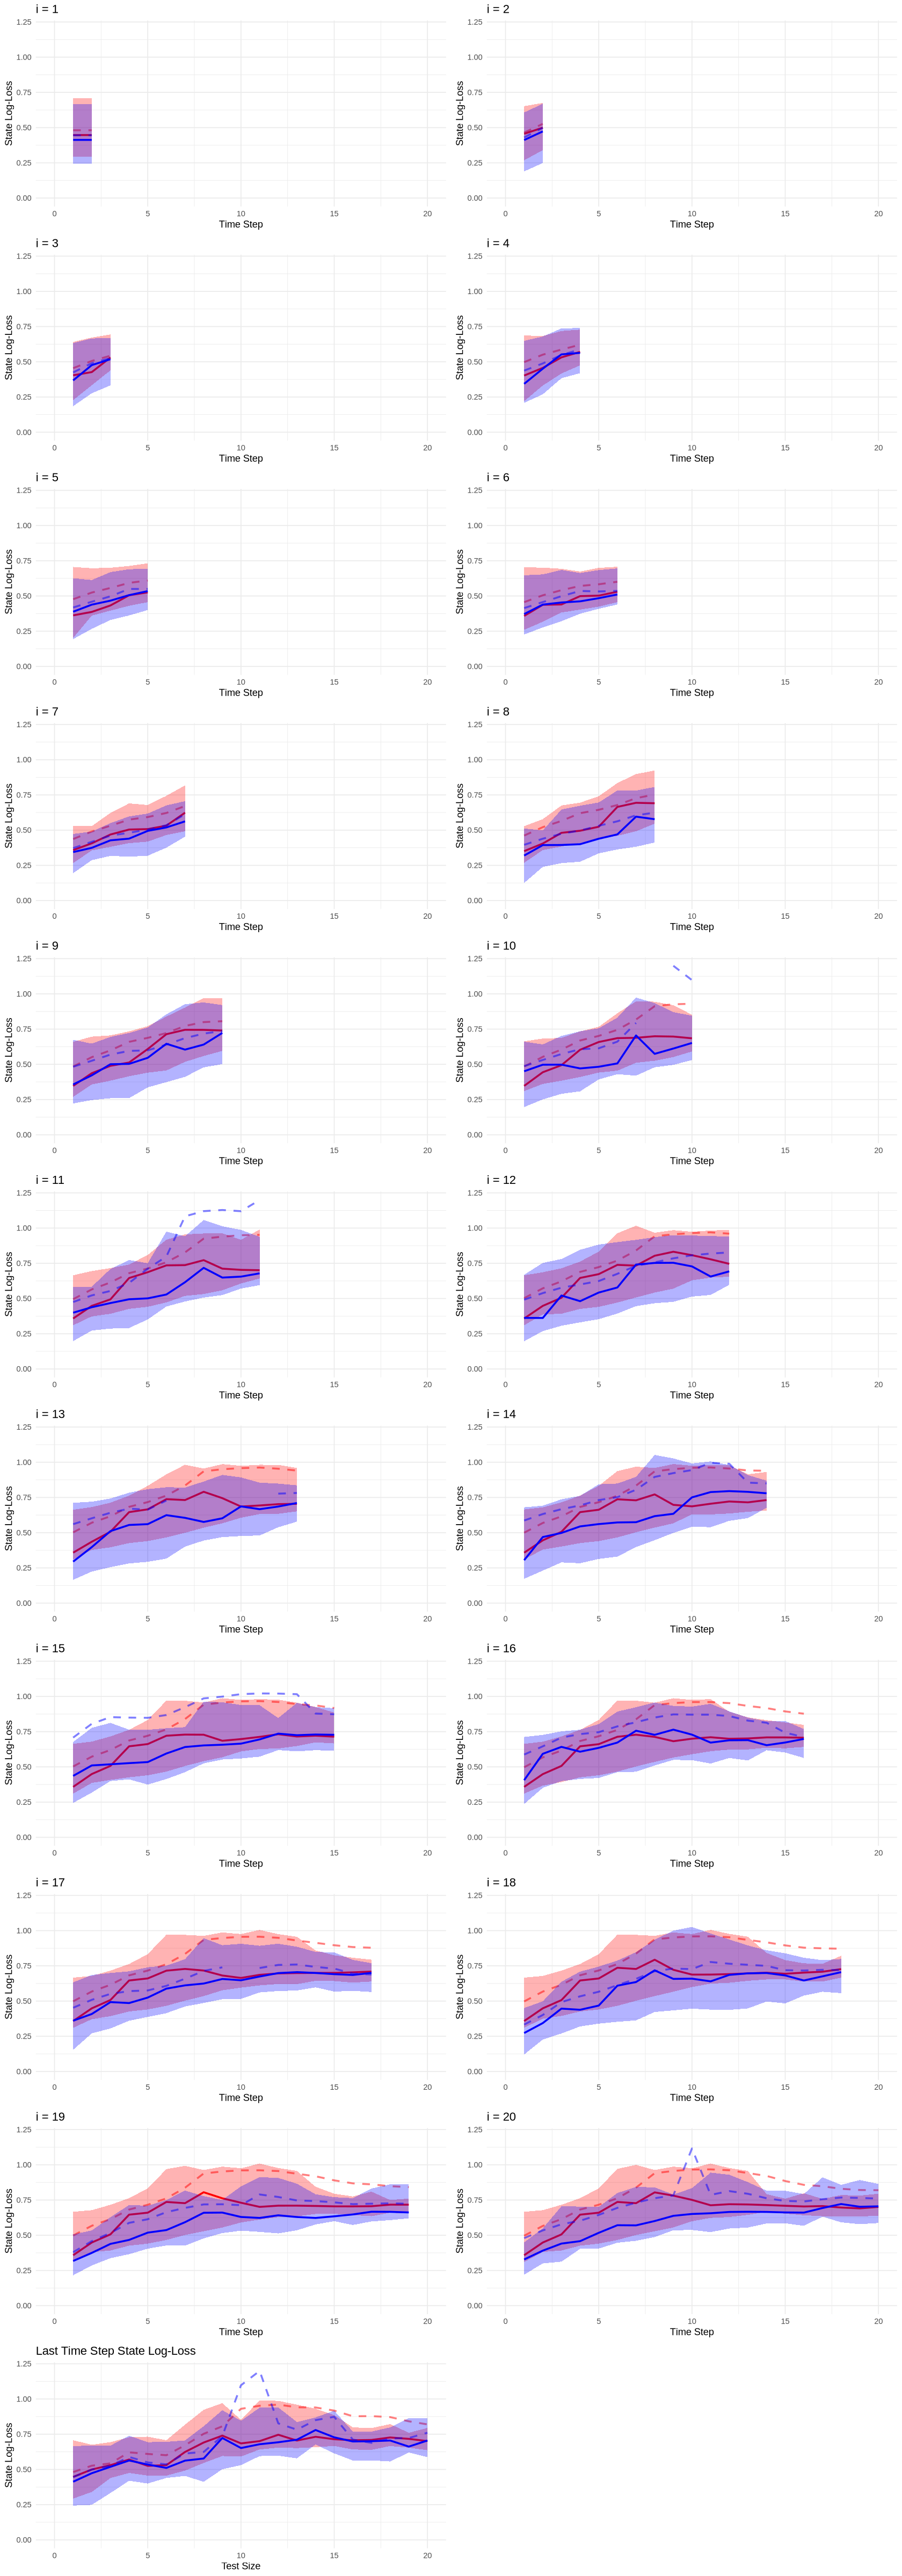

In [11]:
plot_loss <- function(results, type = "state_logloss") {
  safe_rowMeans <- function(x) {
    if (is.null(dim(x))) return(rep(mean(x, na.rm = TRUE), 2))
    rowMeans(x, na.rm = TRUE)
  }
  safe_rowPercentile <- function(x, p) {
    if (is.null(dim(x))) return(rep(quantile(x, probs = p, na.rm = TRUE)[[1]], 2))
    apply(x, 1, quantile, probs = p, na.rm = TRUE)
  }
  average_accross_series <- function(results, model, type) {
    logloss <- sapply(results, function(series)
      sapply(series, function(x) {
        x[[model]][[type]]
      })
    )
    logloss_mean <- sapply(logloss, safe_rowMeans)
    logloss_25th <- sapply(logloss, function(x)
      safe_rowPercentile(x, 0.25)
    )
    logloss_75th <- sapply(logloss, function(x)
      safe_rowPercentile(x, 0.75)
    )
    logloss_50th <- sapply(logloss, function(x)
      safe_rowPercentile(x, 0.50)
    )
    list(
      mean   = logloss_mean,
      p25    = logloss_25th,
      p75    = logloss_75th,
      median = logloss_50th
    )
  }
  cov_loss <- average_accross_series(results, "cov_model", type)
  tsx_loss <- average_accross_series(results, "tsx_model", type)

  last_row_plot_data <- data.frame(
      x = 1:length(results),
      median = sapply(tsx_loss$median, tail, 1),
      lower = sapply(tsx_loss$p25, tail, 1),
      upper = sapply(tsx_loss$p75, tail, 1),
      mean = sapply(tsx_loss$mean, tail, 1),
      cov_median = sapply(cov_loss$median, tail, 1),
      cov_lower = sapply(cov_loss$p25, tail, 1),
      cov_upper = sapply(cov_loss$p75, tail, 1),
      cov_mean = sapply(cov_loss$mean, tail, 1)
    )
  combined_plot <-
    ggplot(last_row_plot_data, aes(x = x)) +
      geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
      geom_line(aes(y = median), color = "red", linewidth = 1) +
      geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
      geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
      geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
      geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
      labs(x = "Test Size", y = "State Log-Loss", title = "Last Time Step State Log-Loss") +
      theme_minimal() +
      {if (type == "state_logloss") ylim(0, 1.2)} +
      xlim(0, 20)
  
  plot_list <- lapply(1:length(results), function(i) {
    plot_data <- data.frame(
      x = 1:length(tsx_loss$median[[i]]),
      median = tsx_loss$median[[i]],
      lower = tsx_loss$p25[[i]],
      upper = tsx_loss$p75[[i]],
      mean = tsx_loss$mean[[i]],
      cov_median = cov_loss$median[[i]],
      cov_lower = cov_loss$p25[[i]],
      cov_upper = cov_loss$p75[[i]],
      cov_mean = cov_loss$mean[[i]]
    )
  
  ggplot(plot_data, aes(x = x)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
    geom_line(aes(y = median), color = "red", linewidth = 1) +
    geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
    geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
    geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    labs(x = "Time Step", y = "State Log-Loss", title = paste("i =", i)) +
    {if (type == "state_logloss") ylim(0, 1.2)} +
    xlim(0, 20) +
    theme_minimal()
  })
  plot_list[[length(results) + 1]] <- combined_plot
  options(repr.plot.width = 14, repr.plot.height = 40)
  grid.arrange(grobs = plot_list, ncol = 2)
}

plot_loss(results, type = "state_logloss")

## Plot samples of individual trials

In [16]:
results[[3]][[2]]$cov_model

$state_forecast
          [,1]       [,2]         [,3]
[1,] 0.9883859 0.01161405 3.068319e-13
[2,] 0.9611159 0.03828416 5.998981e-04
[3,] 0.8369036 0.15744909 5.647333e-03

$true_states
          state1      state2       state3
[660,] 0.9977465 0.002253455 1.494443e-15
[661,] 0.9946662 0.005333289 5.391639e-07
[662,] 0.9787624 0.021237622 9.077859e-11

$state_logloss
             [,1]
[660,] 0.02169606
[661,] 0.05685371
[662,] 0.21352614

$prediction_logloss
[1] -1.4507371 -1.2995069 -0.6873918

$hmm
#######################
## Observation model ##
#######################
+ TSX_Composite ~ norm(mean, sd) 
  * mean.state1 ~ 1
  * mean.state2 ~ 1
  * mean.state3 ~ 1
  * sd.state1 ~ 1
  * sd.state2 ~ 1
  * sd.state3 ~ 1
 
> Initial observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.030  -0.001   0.003
TSX_Composite.sd     0.062   0.020   0.008

#########################
## State process model ##
#########################
                      

In [17]:
results[[3]][[2]]$tsx_model

$state_forecast
          [,1]       [,2]         [,3]
[1,] 0.9671730 0.03282702 7.364363e-09
[2,] 0.9354848 0.06305176 1.463415e-03
[3,] 0.9049005 0.09088905 4.210435e-03

$true_states
          state1      state2       state3
[660,] 0.9964174 0.003582557 1.114706e-11
[661,] 0.9942105 0.005789381 1.294975e-07
[662,] 0.9916313 0.008368679 3.330110e-11

$state_logloss
             [,1]
[660,] 0.04549817
[661,] 0.08230578
[662,] 0.11916305

$prediction_logloss
[1] -1.6142093 -1.4395132 -0.8771916

$hmm
#######################
## Observation model ##
#######################
+ TSX_Composite ~ norm(mean, sd) 
  * mean.state1 ~ 1
  * mean.state2 ~ 1
  * mean.state3 ~ 1
  * sd.state1 ~ 1
  * sd.state2 ~ 1
  * sd.state3 ~ 1
 
> Initial observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.021  -0.001   0.003
TSX_Composite.sd     0.056   0.019   0.008

#########################
## State process model ##
#########################
        state 1 state 

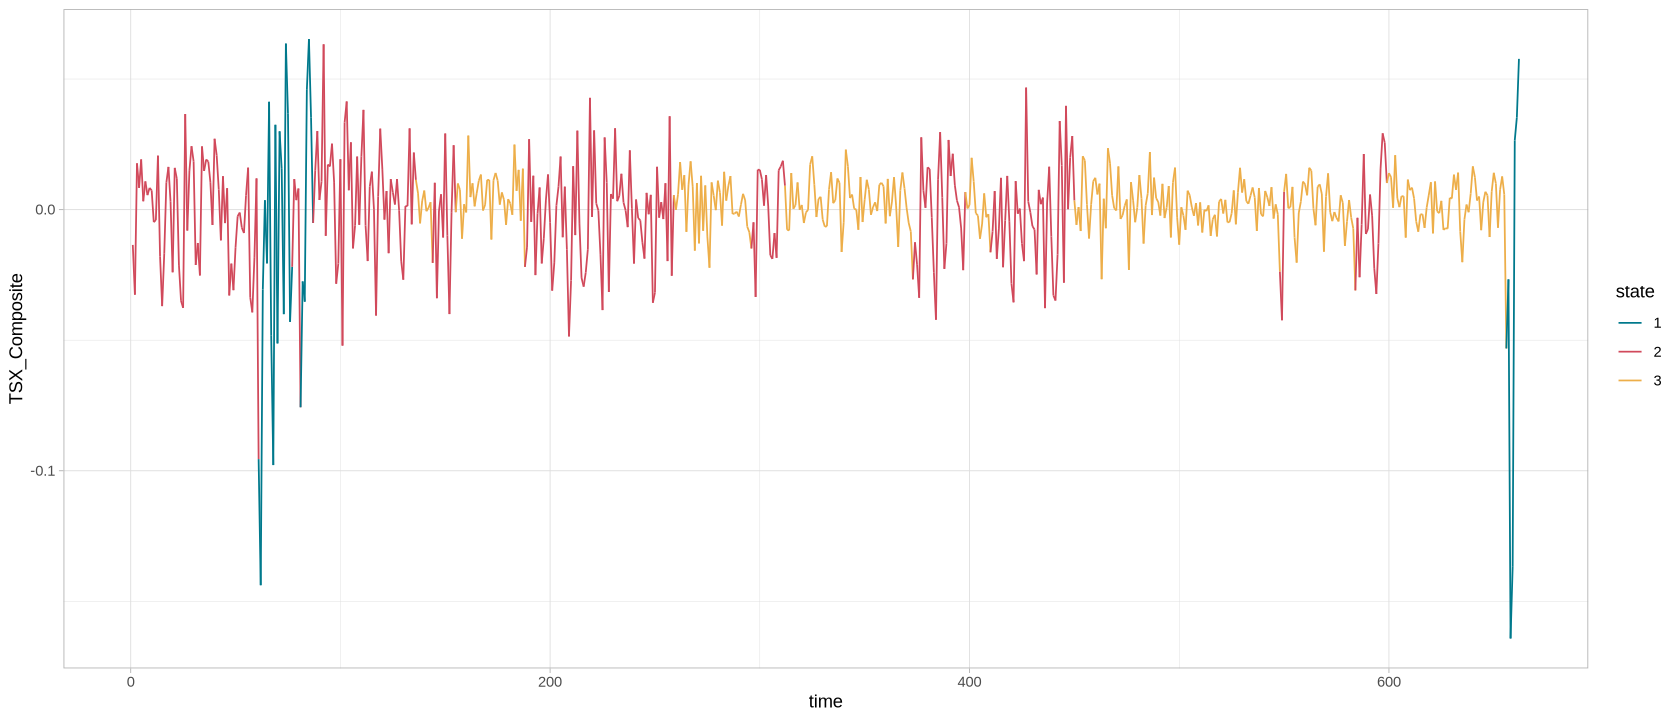

In [14]:
options(repr.plot.width = 14, repr.plot.height = 6)
results[[3]][[2]]$cov_model$hmm$plot_ts("TSX_Composite")

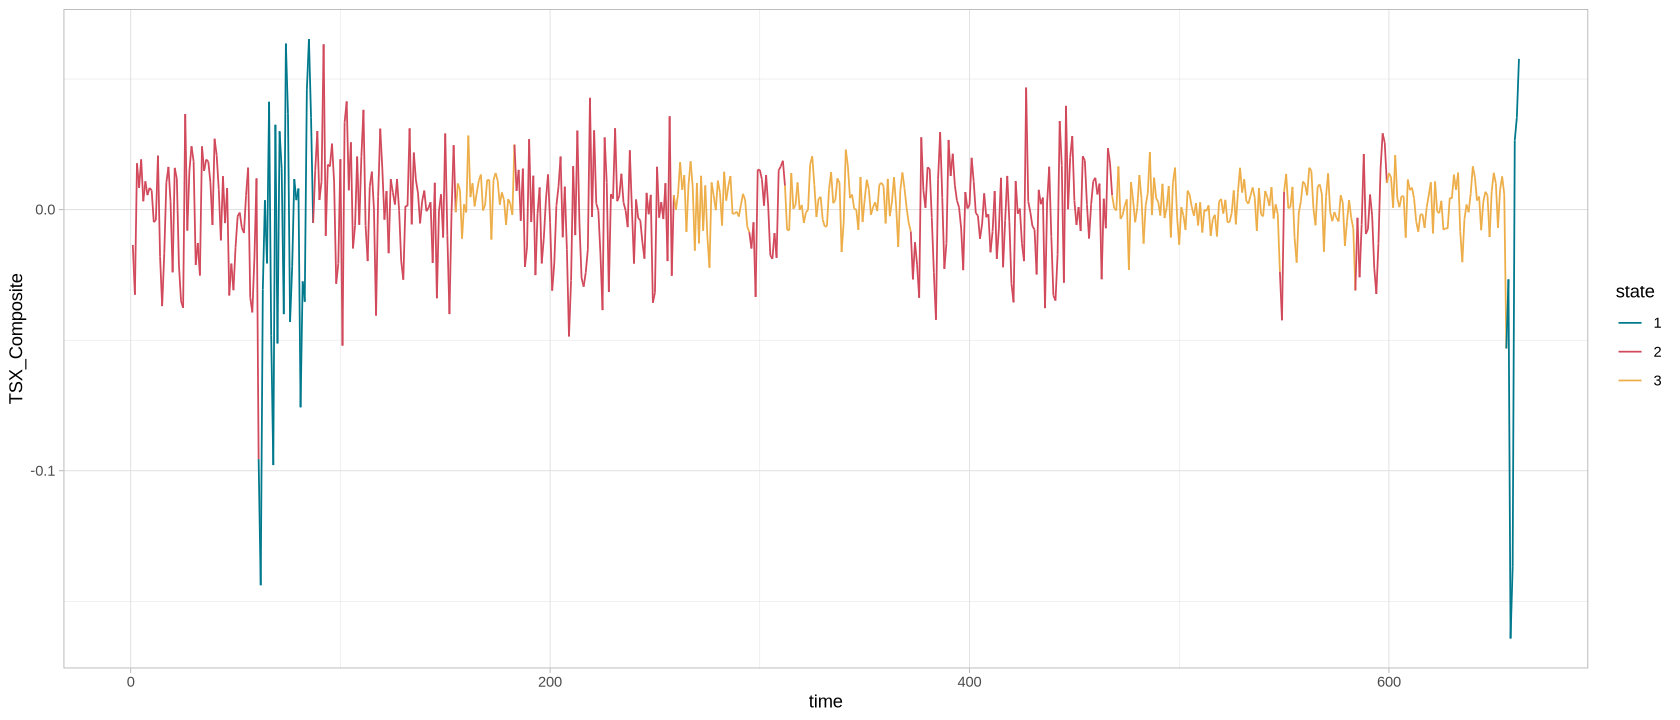

In [15]:
results[[3]][[2]]$tsx_model$hmm$plot_ts("TSX_Composite")